# Metrics for unpaired image-to-image translation 

> Defines functionality for implementing metrics for unpaired image-to-image translation, including common metrics like FID, KID, etc.

In [ ]:
#default_exp metrics

In [ ]:
#export
from fastai.vision.all import *
from fastai.basics import *
from typing import List
from fastai.vision.gan import *
from upit.models.cyclegan import *
from upit.data.unpaired import *
from upit.train.cyclegan import *
from torchvision import models
from scipy import linalg

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
set_seed(999, reproducible=True)

## Fréchet Inception Distance

This code is based on [this implementation](https://github.com/mseitzer/pytorch-fid) and [this implementation](https://github.com/clovaai/stargan-v2/blob/master/metrics/fid.py), adapted to fastai's metric API.


In [ ]:
class InceptionV3(nn.Module):
    def __init__(self):
        super().__init__()
        inception = models.inception_v3(pretrained=True)
        self.block1 = nn.Sequential(
            inception.Conv2d_1a_3x3, inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2))
        self.block2 = nn.Sequential(
            inception.Conv2d_3b_1x1, inception.Conv2d_4a_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2))
        self.block3 = nn.Sequential(
            inception.Mixed_5b, inception.Mixed_5c,
            inception.Mixed_5d, inception.Mixed_6a,
            inception.Mixed_6b, inception.Mixed_6c,
            inception.Mixed_6d, inception.Mixed_6e)
        self.block4 = nn.Sequential(
            inception.Mixed_7a, inception.Mixed_7b,
            inception.Mixed_7c,
            nn.AdaptiveAvgPool2d(output_size=(1, 1)))

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return x.view(x.size(0), -1)

In [ ]:
class FrechetInceptionDistance(Metric):
    def __init__(self, model=None, device='cuda', yb_idx=0, pred_idx=1):
        store_attr()
        self.model = model
        if self.model is None: self.model = self.get_inception_model()
        self.stats_pred = []
        self.stats_targ = []

    
    @staticmethod
    def get_inception_model(): return InceptionV3()
    
    @staticmethod
    def calc_activations_for_batch(batch, model, device=None):
        
        model = model.to(device)
        batch = batch.to(device)
        with torch.no_grad(): pred = model(batch)

        pred = pred.cpu().numpy()
        
        model = model.cpu()
        return pred

    @staticmethod
    def calculate_activation_statistics(activations):
        mu = np.mean(activations,axis=0)
        sigma = np.cov(activations, rowvar=False)
        return mu, sigma
    
    @staticmethod
    def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
        mu1 = np.atleast_1d(mu1)
        mu2 = np.atleast_1d(mu2)

        sigma1 = np.atleast_2d(sigma1)
        sigma2 = np.atleast_2d(sigma2)

        assert mu1.shape == mu2.shape, 'Training and test mean vectors have different lengths'
        assert sigma1.shape == sigma2.shape, 'Training and test covariances have different dimensions'
        
        diff = mu1 - mu2
        
        # Product might be almost singular
        covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
        if not np.isfinite(covmean).all():
            msg = ('fid calculation produces singular product; '
                   'adding %s to diagonal of cov estimates') % eps
            print(msg)
            offset = np.eye(sigma1.shape[0]) * eps
            covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

        # Numerical error might give slight imaginary component
        if np.iscomplexobj(covmean):
            if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
                m = np.max(np.abs(covmean.imag))
                raise ValueError('Imaginary component {}'.format(m))
            covmean = covmean.real

        tr_covmean = np.trace(covmean)

        return (diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean)

    
    def accumulate(self, learn):
        self.stats_pred.append(self.calc_activations_for_batch(learn.pred[self.pred_idx], self.model, self.device))
        self.stats_targ.append(self.calc_activations_for_batch(learn.yb[self.yb_idx], self.model, self.device))
    
    
    @property
    def value(self): 
        stats_pred_arr = np.concatenate(self.stats_pred,axis=0)
        stats_targ_arr = np.concatenate(self.stats_targ,axis=0)
        mu1, sigma1 = self.calculate_activation_statistics(stats_pred_arr)
        mu2, sigma2 = self.calculate_activation_statistics(stats_targ_arr)
        return self.calculate_frechet_distance(mu1, sigma1, mu2, sigma2)
        
    def reset(self):
        self.stats_pred = []
        self.stats_targ = []
        

The `FrechetInceptionDistance` metric works by initializing an Inception model, extracting Inception activation features for each batch of predictions and example images (target), and at the end calculate the statistics and the Frechet distance. Below are test for each of these components. 

In [ ]:
fid = FrechetInceptionDistance(device='cpu')

In [ ]:
size = (224, 224, 3)
arrays = [np.zeros(size), np.ones(size) * 0.5, np.ones(size)]*2
img_like_tensor = torch.from_numpy(np.array(arrays)).float()
test_eq(fid.calc_activations_for_batch(img_like_tensor.permute(0,3,1,2),model=fid.model,device='cpu').shape, (img_like_tensor.shape[0],2048))

In [ ]:
class fake_model(nn.Module):
    def __init__(self): super(fake_model, self).__init__()
    def forward(self,x): return x.mean(dim=(2,3))

size = (4, 4, 3)
arrays = [np.zeros(size), np.ones(size) * 0.5, np.ones(size)]
input_tensor = torch.from_numpy(np.array(arrays)).float()

stats = fid.calculate_activation_statistics(fid.calc_activations_for_batch(input_tensor.permute(0,3,1,2),model=fake_model()))
test_eq(stats[0], np.ones((3,)) * 0.5)
test_eq(stats[1], np.ones((3, 3)) * 0.25)

In [ ]:
m1, m2 = np.zeros((2048,)), np.ones((2048,))
sigma = np.eye(2048)
# Given equal covariance, FID is just the squared norm of difference
test_eq(fid.calculate_frechet_distance(m1,sigma,m2,sigma), np.sum((m1 - m2)**2))

In [ ]:
class FakeLearner():
    def __init__(self):
        self.yb = [img_like_tensor.permute(0,3,1,2)]
        self.pred = [None, img_like_tensor.permute(0,3,1,2)]
learn = FakeLearner()

In [ ]:
%%time
for i in range(5):
    fid.accumulate(learn)
print(fid.value)

-0.0002026209404561996
CPU times: user 25.7 s, sys: 763 ms, total: 26.5 s
Wall time: 26.5 s


## Quick Test

In [ ]:
#cuda
horse2zebra = untar_data('https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip', force_download=True)
folders = horse2zebra.ls().sorted()
trainA_path = folders[2]
trainB_path = folders[3]
testA_path = folders[0]
testB_path = folders[1]
dls = get_dls(trainA_path, trainB_path,num_A=100)
cycle_gan = CycleGAN(3,3,64)
learn = cycle_learner(dls, cycle_gan,metrics=[FrechetInceptionDistance()],show_img_interval=1)

/home/tmabraham/fastai/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (G_A) that exists in the learner. Use `self.learn.G_A` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/home/tmabraham/fastai/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (G_B) that exists in the learner. Use `self.learn.G_B` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/home/tmabraham/fastai/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (D_A) that exists in the learner. Use `self.learn.D_A` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/home/tmabraham/fastai/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (D_B) that exists in the learner. Use `self.learn.D_B` to avoi

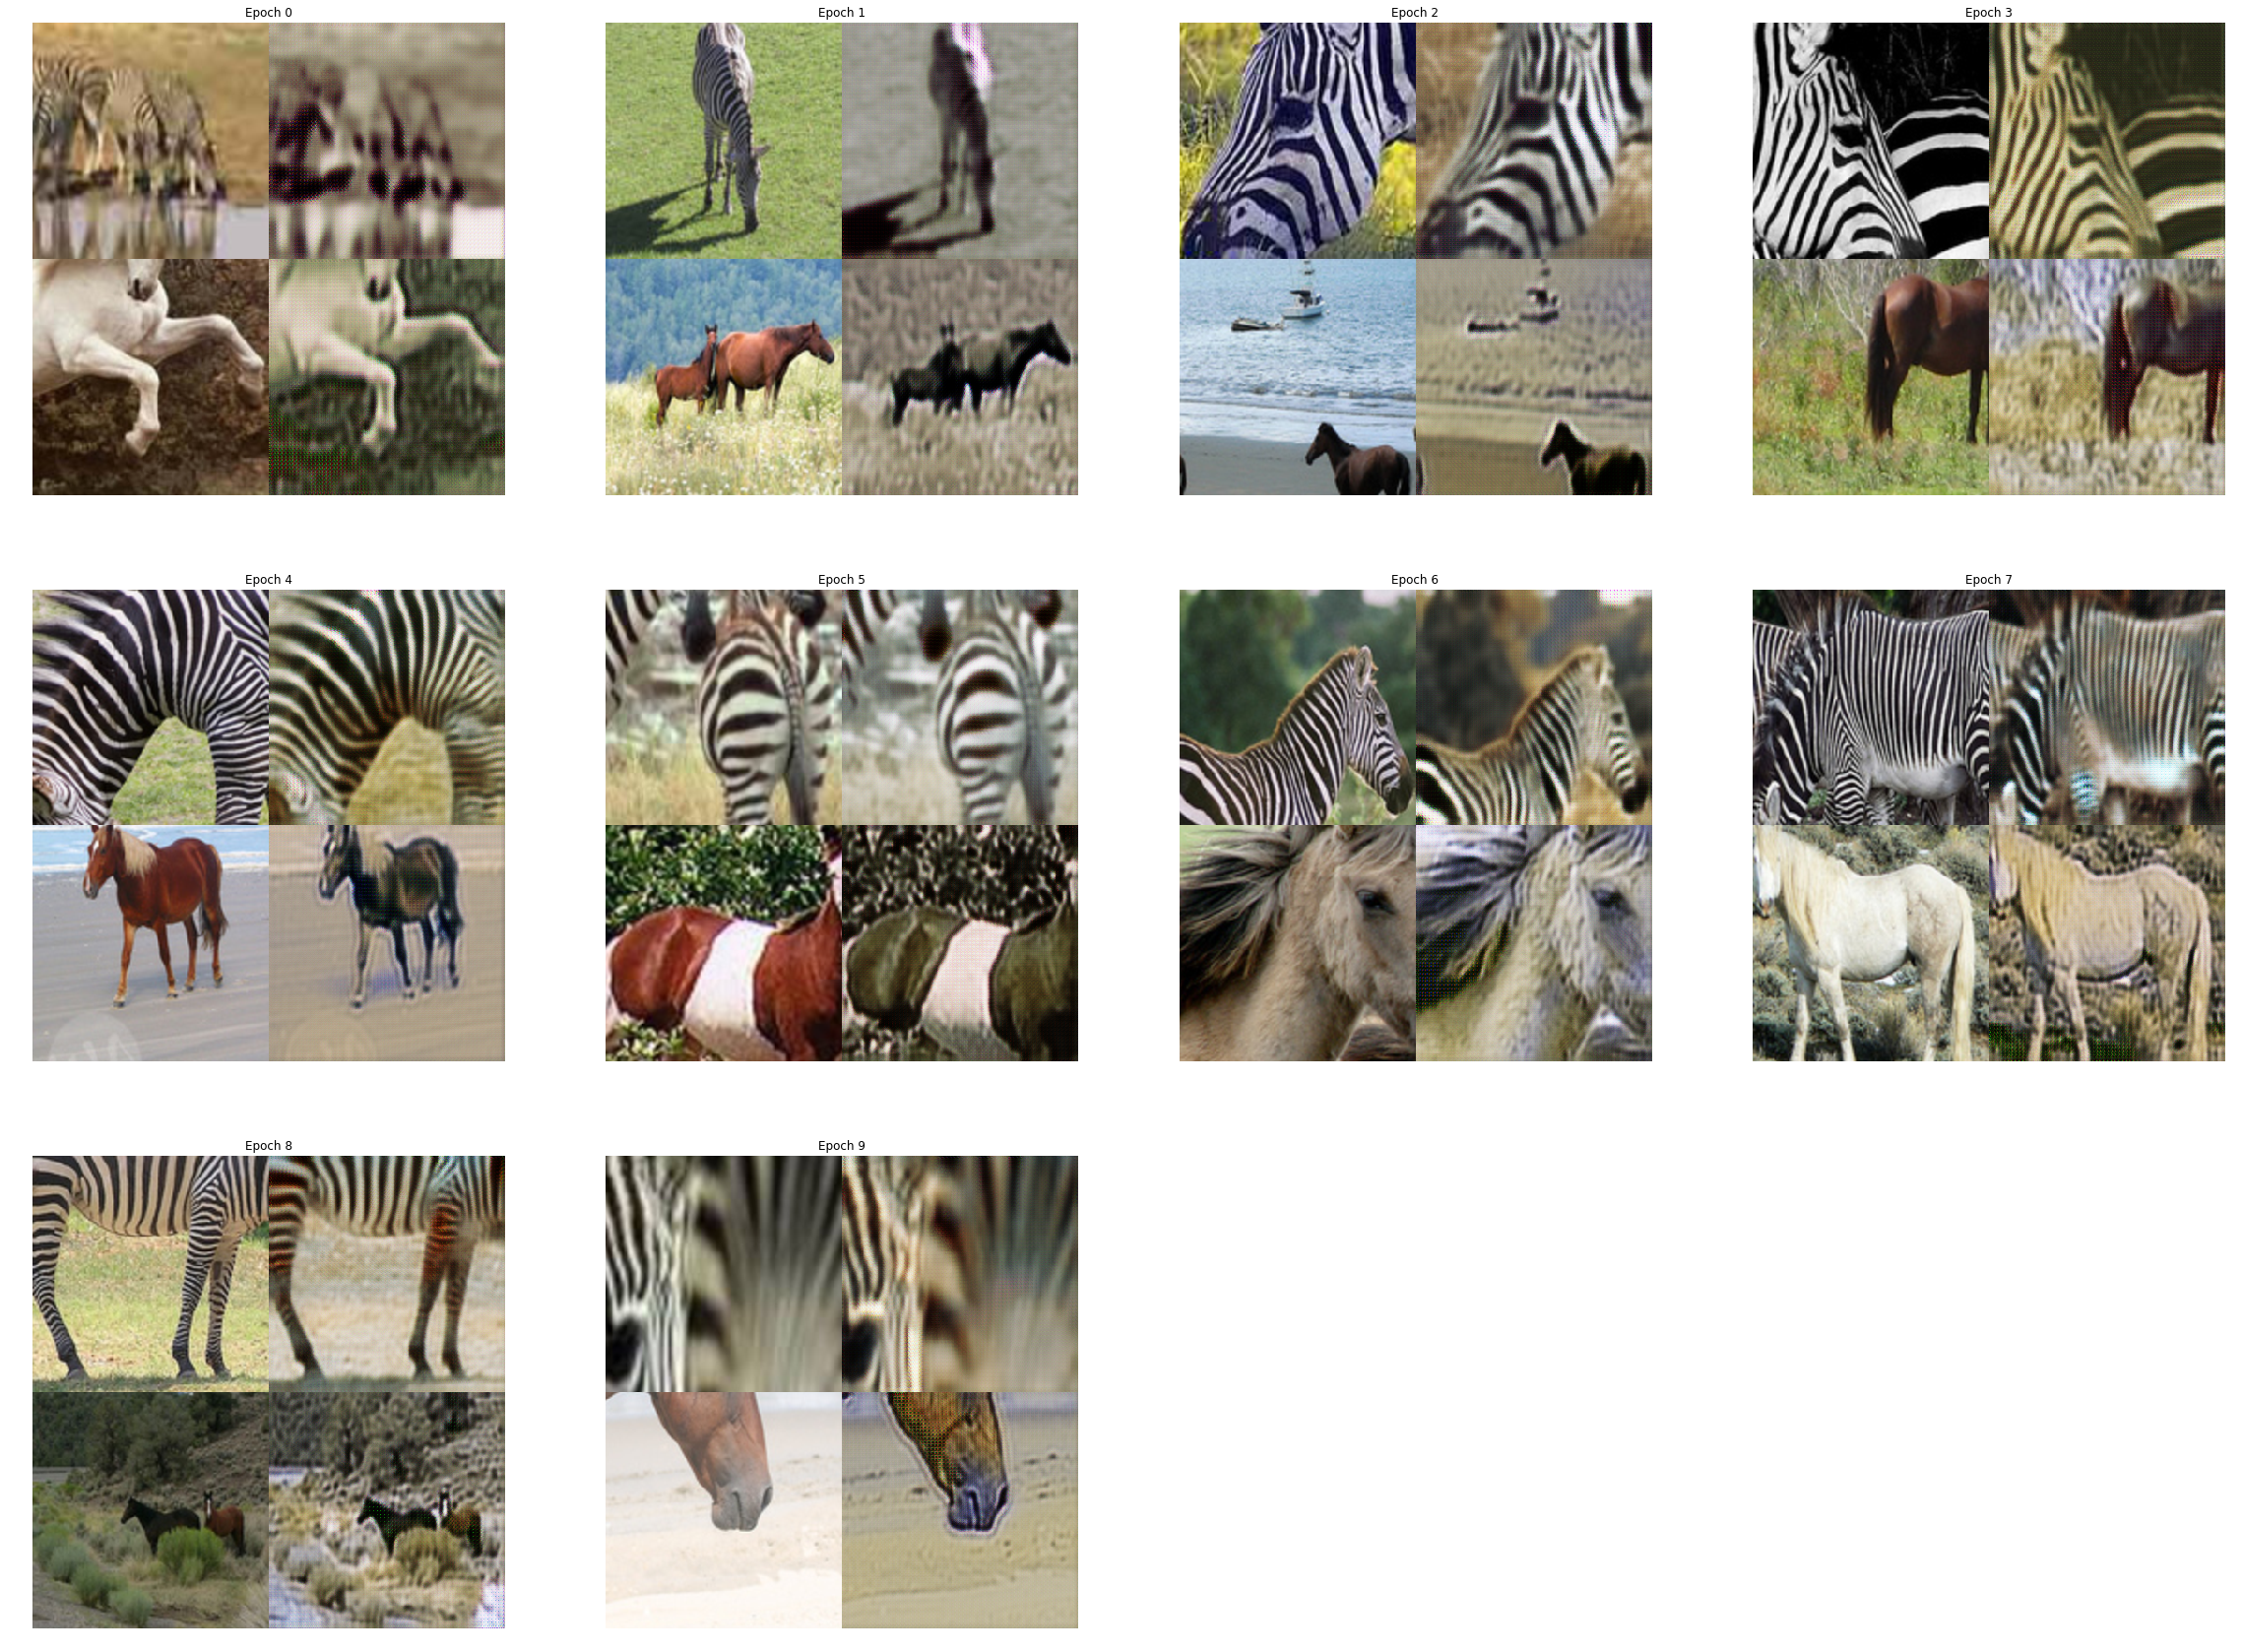

In [ ]:
#cuda
learn.fit_flat_lin(5,5,2e-4)

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01_models.cyclegan.ipynb.
Converted 01b_models.junyanz.ipynb.
Converted 02_data.unpaired.ipynb.
Converted 03_train.cyclegan.ipynb.
Converted 04_inference.cyclegan.ipynb.
Converted 05_metrics.ipynb.
Converted index.ipynb.
